# Two Layer Neural Network


Name:  **Rama Prashanth**  
UID:  **116428941**

## 1. Packages

In [47]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy
from PIL import Image
from scipy import ndimage

import torch
import torch.nn as nn

In [48]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Dataset

**Problem Statement**: You are given a dataset ("data/train_catvnoncat.h5", "data/test_catvnoncat.h5") containing:
    - a training set of m_train images labelled as cat (1) or non-cat (0)
    - a test set of m_test images labelled as cat and non-cat
    - each image is of shape (num_px, num_px, 3) where 3 is for the 3 channels (RGB).

Let's get more familiar with the dataset. Load the data by completing the function and run the cell below.

In [49]:
def load_data(train_file, test_file):
    # Load the training data
    train_dataset = h5py.File(train_file, 'r')
    
    # Separate features(x) and labels(y) for training set
    train_set_x_orig = np.array(train_dataset["train_set_x"])
    train_set_y_orig = np.array(train_dataset["train_set_y"])

    # Load the test data
    test_dataset = h5py.File(test_file, 'r')
    
    # Separate features(x) and labels(y) for training set
    test_set_x_orig = np.array(test_dataset["test_set_x"])
    test_set_y_orig = np.array(test_dataset["test_set_y"])

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes


In [50]:
train_file="data/train_catvnoncat.h5"
test_file="data/test_catvnoncat.h5"
train_x_orig, train_y, test_x_orig, test_y, classes = load_data(train_file, test_file)

The following code will show you an image in the dataset. Feel free to change the index and re-run the cell multiple times to see other images. 

y = 0. It's a non-cat picture.


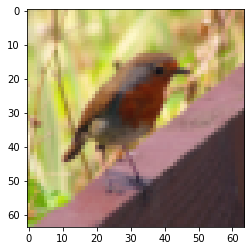

In [51]:
# Example of a picture
index = 10
plt.imshow(train_x_orig[index])
print ("y = " + str(train_y[0,index]) + ". It's a " + classes[train_y[0,index]].decode("utf-8") +  " picture.")

In [52]:
# Explore your dataset 
m_train = train_x_orig.shape[0]
num_px = train_x_orig.shape[1]
m_test = test_x_orig.shape[0]

print ("Number of training examples: " + str(m_train))
print ("Number of testing examples: " + str(m_test))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_x_orig shape: " + str(train_x_orig.shape))
print ("train_y shape: " + str(train_y.shape))
print ("test_x_orig shape: " + str(test_x_orig.shape))
print ("test_y shape: " + str(test_y.shape))

Number of training examples: 209
Number of testing examples: 50
Each image is of size: (64, 64, 3)
train_x_orig shape: (209, 64, 64, 3)
train_y shape: (1, 209)
test_x_orig shape: (50, 64, 64, 3)
test_y shape: (1, 50)


As usual, you reshape and standardize the images before feeding them to the network.

<img src="imvectorkiank.png" style="width:450px;height:300px;">

<caption><center> <u>Figure 1</u>: Image to vector conversion. <br> </center></caption>

In [53]:
# Reshape the training and test examples 
train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1).T   # The "-1" makes reshape flatten the remaining dimensions
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1).T

# Standardize data to have feature values between 0 and 1.
train_x = train_x_flatten/255.
test_x = test_x_flatten/255.

print ("train_x's shape: " + str(train_x.shape))
print ("test_x's shape: " + str(test_x.shape))

train_x's shape: (12288, 209)
test_x's shape: (12288, 50)


## 3 - Architecture of your model

Now that you are familiar with the dataset, it is time to build a deep neural network to distinguish cat images from non-cat images.

###  2-layer neural network

<img src="2layerNN_kiank.png" style="width:650px;height:400px;">
<caption><center> <u>Figure 2</u>: 2-layer neural network. <br> The model can be summarized as: ***INPUT -> LINEAR -> RELU -> LINEAR -> SIGMOID -> OUTPUT***. </center></caption>

<u>Detailed Architecture of figure 2</u>:
- The input is a (64,64,3) image which is flattened to a vector of size $(12288,1)$. 
- The corresponding vector: $[x_0,x_1,...,x_{12287}]^T$ is then multiplied by the weight matrix $W^{[1]}$ of size $(n^{[1]}, 12288)$.
- You then add a bias term and take its relu to get the following vector: $[a_0^{[1]}, a_1^{[1]},..., a_{n^{[1]}-1}^{[1]}]^T$.
- You multiply the resulting vector by $W^{[2]}$ and add your intercept (bias). 
- Finally, you take the sigmoid of the result. If it is greater than 0.5, you classify it to be a cat.


###  General methodology

As usual you will follow the Deep Learning methodology to build the model:
    1. Initialize parameters / Define hyperparameters
    2. Loop for num_iterations:
        a. Forward propagation
        b. Compute loss function
        c. Backward propagation
        d. Update parameters (using parameters, and grads from backprop) 
    4. Use trained parameters to predict labels

Let's now implement those the model!

In [66]:
### CONSTANTS DEFINING THE MODEL ####
# n_x - input size
# n_h - hidden layer size
# n_y - output size

n_x = 12288     # num_px * num_px * 3
n_h = 7
n_y = 1
layers_dims = (n_x, n_h, n_y)

In [71]:
model = nn.Sequential(nn.Linear(n_x, n_h),
                 nn.ReLU(),
                 nn.Linear(n_h, n_y),
                 nn.Sigmoid())

In [72]:
# Construct the loss function
criterion = nn.CrossEntropyLoss()

In [73]:
def two_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_loss=False):
    """
    Implements a two-layer neural network: LINEAR->RELU->LINEAR->SIGMOID.
    
    Arguments:
    X -- input data, of shape (n_x, number of examples)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    layers_dims -- dimensions of the layers (n_x, n_h, n_y)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_loss -- If set to True, this will print the loss every 100 iterations 
    
    Returns:
    parameters -- a dictionary containing W1, W2, b1, and b2
    """
    
    np.random.seed(1)
    losses = []                              # to keep track of the loss
    m = X.shape[1]                           # number of examples
    (n_x, n_h, n_y) = layers_dims
    
    # Construct the optimizer (Stochastic Gradient Descent in this case)
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    
    # Loop (gradient descent)
    for i in range(0, num_iterations):

        # Forward propagation: LINEAR -> RELU -> LINEAR -> SIGMOID.
        y_pred = model(X.float())
        
        # Compute loss
        loss = criterion(y_pred, Y)
        
        # Zero gradients performs backward pass and updates the weights.
        optimizer.zero_grad()

        # Back propagation
        loss.backward()

        # Update the parameters
        optimizer.step()
        
        # Print the loss every 100 training example
        if print_loss and i % 100 == 0:
            print("Loss after iteration {}: {}".format(i, loss.item()))
        if print_loss and i % 100 == 0:
            losses.append(loss.item())
       
    # plot the loss

    plt.plot(np.squeeze(losses))
    plt.ylabel('loss')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return model.parameters()

In [75]:
X = torch.tensor(train_x)
Y = torch.tensor(train_y)

print(X.shape)
print(Y.shape)

X = X.transpose(0, 1)

print(X.shape)

parameters = two_layer_model(X, Y, layers_dims=(n_x, n_h, n_y), learning_rate=0.0075, num_iterations=2500, print_loss=True)

torch.Size([12288, 209])
torch.Size([1, 209])
torch.Size([209, 12288])


RuntimeError: size mismatch, m1: [209 x 7], m2: [1 x 7] at C:\w\1\s\tmp_conda_3.6_095855\conda\conda-bld\pytorch_1579082406639\work\aten\src\TH/generic/THTensorMath.cpp:136

# **Expected Output**:
<table> 
    <tr>
        <td> **Loss after iteration 0**</td>
        <td> 0.6930497356599888 </td>
    </tr>
    <tr>
        <td> **Loss after iteration 100**</td>
        <td> 0.6464320953428849 </td>
    </tr>
    <tr>
        <td> **...**</td>
        <td> ... </td>
    </tr>
    <tr>
        <td> **Loss after iteration 2400**</td>
        <td> 0.048554785628770206 </td>
    </tr>
</table>

Good thing you built a vectorized implementation! Otherwise it might have taken 10 times longer to train this.

Now, you can use the trained parameters to classify images from the dataset. 

***Exercise:*** 
- Implement the forward function
- Implement the predict function below to make prediction on test_images

In [27]:
def two_layer_forward(X, parameters):
    """
    Implement forward propagation for the [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID computation
    
    Arguments:
    X -- data, numpy array of shape (input size, number of examples)
    parameters -- output of initialize_parameters_deep()
    
    Returns:
    AL -- last post-activation value
    caches -- list of caches containing:
                every cache of linear_relu_forward() (there are L-1 of them, indexed from 0 to L-2)
                the cache of linear_sigmoid_forward() (there is one, indexed L-1)
    """

    caches = []
    A = X
    
    # Implement LINEAR -> RELU. Add "cache" to the "caches" list.
    A1, cache1 = linear_activation_forward(A, parameters["W1"], parameters["b1"], "relu")
    caches.append(cache1)
    
    # Implement LINEAR -> SIGMOID. Add "cache" to the "caches" list.
    A2, cache2 = linear_activation_forward(A1, parameters["W2"], parameters["b2"], "sigmoid")
    caches.append(cache2)
    
    assert(A2.shape == (1,X.shape[1]))
            
    return A2, caches

In [28]:
def predict(X, y, parameters):
    """
    This function is used to predict the results of a  L-layer neural network.
    
    Arguments:
    X -- data set of examples you would like to label
    parameters -- parameters of the trained model
    
    Returns:
    p -- predictions for the given dataset X
    """
    
    m = X.shape[1]
    n = len(parameters) // 2 # number of layers in the neural network
    p = np.zeros((1,m))
    
    # Forward propagation
    probas, caches =  two_layer_forward(X, parameters)
    
    # convert probas to 0/1 predictions
    for i in range(0, probas.shape[1]):
        if (probas[0, i] > 0.5):
            p[0][i] = 1
        else:
            p[0][i] = 0
        
    print("Accuracy: "  + str(np.sum((p == y)/m)))
        
    return p

In [29]:
predictions_train = predict(train_x, train_y, parameters)

Accuracy: 0.9999999999999998


In [30]:
predictions_test = predict(test_x, test_y, parameters)

Accuracy: 0.72


***Exercise:***
Identify the hyperparameters in the model and For each hyperparameter
- Briefly explain its role
- Explore a range of values and describe their impact on (a) training loss and (b) test accuracy
- Report the best hyperparameter value found.


***Report:***
The hyperparameters are variable that define the network structure and determine how the network is trained. The hyperparameters in the model are
- Learning rate : how quickly the network updates its parameters and proceeds towards convergence
- Number of iterations : number of times required for the model to reach convergence
- Hidden layers: layers between input layer and output layer

Experimenting with learning rate and number of iterations.

Loss after iteration 0: 0.693049735659989
Loss after iteration 100: 0.6464320953428849
Loss after iteration 200: 0.6325140647912677
Loss after iteration 300: 0.6015024920354665
Loss after iteration 400: 0.5601966311605747
Loss after iteration 500: 0.5158304772764729
Loss after iteration 600: 0.47549013139433255
Loss after iteration 700: 0.4339163151225749
Loss after iteration 800: 0.40079775362038894
Loss after iteration 900: 0.3580705011323798
Loss after iteration 1000: 0.3394281538366412
Loss after iteration 1100: 0.30527536361962637
Loss after iteration 1200: 0.27491377282130197
Loss after iteration 1300: 0.2468176821061484
Loss after iteration 1400: 0.19850735037466075
Loss after iteration 1500: 0.17448318112556627
Loss after iteration 1600: 0.17080762978096214
Loss after iteration 1700: 0.11306524562164723
Loss after iteration 1800: 0.09629426845937147
Loss after iteration 1900: 0.08342617959726863
Loss after iteration 2000: 0.0743907870431908
Loss after iteration 2100: 0.06630748

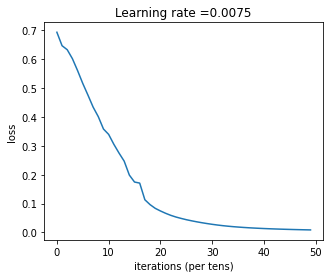

In [31]:
# (2) Learning Rate=0.0075, Num of Iterations=5000
parameters = two_layer_model(train_x, train_y, layers_dims=(n_x, n_h, n_y), learning_rate=0.0075, num_iterations=5000, print_loss=True)

In [32]:
predictions_train = predict(train_x, train_y, parameters)

Accuracy: 0.9999999999999998


In [33]:
predictions_test = predict(test_x, test_y, parameters)

Accuracy: 0.7000000000000001


Loss after iteration 0: 0.693049735659989
Loss after iteration 100: 0.6429673956634753
Loss after iteration 200: 0.6139330587122018
Loss after iteration 300: 0.5603909238662338
Loss after iteration 400: 0.5030563524628464
Loss after iteration 500: 0.4698443892342186
Loss after iteration 600: 0.4355621445123247
Loss after iteration 700: 0.40986977972092914
Loss after iteration 800: 0.3703324586925941
Loss after iteration 900: 0.2801254981389029
Loss after iteration 1000: 0.29654878488824177
Loss after iteration 1100: 0.1962538798352096
Loss after iteration 1200: 0.3552933244720939
Loss after iteration 1300: 0.15117073173355464
Loss after iteration 1400: 0.12822053502639688
Loss after iteration 1500: 0.10367329243705152
Loss after iteration 1600: 0.0933708195636492
Loss after iteration 1700: 0.08626919003765143
Loss after iteration 1800: 0.06430869400356842
Loss after iteration 1900: 0.055478150497232766
Loss after iteration 2000: 0.047190983560532064
Loss after iteration 2100: 0.0407888

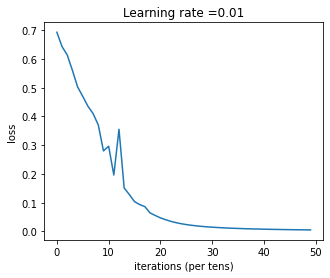

In [34]:
# (3) Learning Rate=0.01, Num of Iterations=5000
parameters = two_layer_model(train_x, train_y, layers_dims=(n_x, n_h, n_y), learning_rate=0.01, num_iterations=5000, print_loss=True)

In [35]:
predictions_train = predict(train_x, train_y, parameters)

Accuracy: 0.9999999999999998


In [36]:
predictions_test = predict(test_x, test_y, parameters)

Accuracy: 0.72


Loss after iteration 0: 0.693049735659989
Loss after iteration 100: 0.6145315364650429
Loss after iteration 200: 0.5488114210847703
Loss after iteration 300: 0.5058825075279194
Loss after iteration 400: 0.48569516783868544
Loss after iteration 500: 0.4048243720249345
Loss after iteration 600: 0.2732678832221182
Loss after iteration 700: 0.30073012628030377
Loss after iteration 800: 0.17329057983694227
Loss after iteration 900: 0.18291049276671917
Loss after iteration 1000: 0.13385565447873146
Loss after iteration 1100: 0.10595747519535126
Loss after iteration 1200: 0.07228866697883789
Loss after iteration 1300: 0.1774616196145582
Loss after iteration 1400: 0.03901303125966093
Loss after iteration 1500: 0.025658622447240285
Loss after iteration 1600: 0.020268587112739076
Loss after iteration 1700: 0.01658701283403051
Loss after iteration 1800: 0.013873288580346277
Loss after iteration 1900: 0.011852797250082169
Loss after iteration 2000: 0.010283563597833627
Loss after iteration 2100: 0

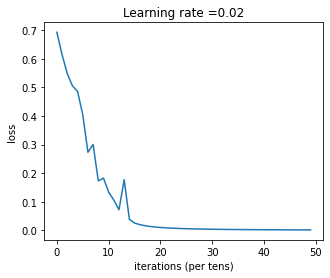

In [37]:
# (4) Learning Rate=0.02, Num of Iterations=5000
parameters = two_layer_model(train_x, train_y, layers_dims=(n_x, n_h, n_y), learning_rate=0.02, num_iterations=5000, print_loss=True)

In [38]:
predictions_train = predict(train_x, train_y, parameters)

Accuracy: 0.9999999999999998


In [39]:
predictions_test = predict(test_x, test_y, parameters)

Accuracy: 0.7


Loss after iteration 0: 0.693049735659989
Loss after iteration 100: 0.5619848087105088
Loss after iteration 200: 0.5431597368032648
Loss after iteration 300: 0.47223340373422207
Loss after iteration 400: 0.3553175029359639
Loss after iteration 500: 0.3291699923862487
Loss after iteration 600: 0.3167907370451563
Loss after iteration 700: 0.21048766105925854
Loss after iteration 800: 0.15751188890039813
Loss after iteration 900: 0.07383913770234714
Loss after iteration 1000: 0.047895499158278655
Loss after iteration 1100: 0.030910824116957638
Loss after iteration 1200: 0.022444957086082202
Loss after iteration 1300: 0.0170272751444631
Loss after iteration 1400: 0.013428523507592131
Loss after iteration 1500: 0.010840950614114398
Loss after iteration 1600: 0.009019915149393577
Loss after iteration 1700: 0.007685289774679797
Loss after iteration 1800: 0.006643699254909727
Loss after iteration 1900: 0.005817278179735696
Loss after iteration 2000: 0.0051552460757748764
Loss after iteration 2

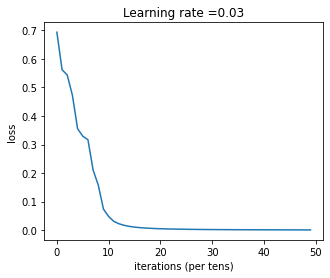

In [40]:
# (5) Learning Rate=0.03, Num of Iterations=5000
parameters = two_layer_model(train_x, train_y, layers_dims=(n_x, n_h, n_y), learning_rate=0.03, num_iterations=5000, print_loss=True)

In [41]:
predictions_train = predict(train_x, train_y, parameters)

Accuracy: 0.9999999999999998


In [42]:
predictions_test = predict(test_x, test_y, parameters)

Accuracy: 0.74


The range of values experimented are as follows:
- learning_rate=0.0075, num_iterations=2500, n_h=7 -> training_loss=0.04855478562877016, test_accuracy=0.72
- learning_rate=0.0075 , num_iterations=5000, n_h=7 -> training_loss=0.008719375589196448, test_accuracy=0.7000000000000001
- learning_rate=0.01 , num_iterations=5000, n_h=7 -> training_loss=0.005256576439731791, test_accuracy=0.72
- learning_rate=0.02 , num_iterations=5000, n_h=7 -> training_loss=0.0016985912700763796, test_accuracy=0.7
- learning_rate=0.03 , num_iterations=5000, n_h=7 -> training_loss=0.0008597927494921494, test_accuracy=0.74

It can be seen that some range of valus overfitted and did not converge well. Also, increase in num of iterations validation accuracy starts decreasing even when training accuracy is increasing(overfitting).

Hence, optimal hyperparameters found are
- learning_rate=0.03
- num_iterations=5000

##  Results Analysis

First, let's take a look at some images the 2-layer model labeled incorrectly. This will show a few mislabeled images.

In [43]:
def print_mislabeled_images(classes, X, y, p):
    """
    Plots images where predictions and truth were different.
    X -- dataset
    y -- true labels
    p -- predictions
    """
    a = p + y
    mislabeled_indices = np.asarray(np.where(a == 1))
    plt.rcParams['figure.figsize'] = (40.0, 40.0) # set default size of plots
    num_images = len(mislabeled_indices[0])
    for i in range(num_images):
        index = mislabeled_indices[1][i]
        
        plt.subplot(2, num_images, i + 1)
        plt.imshow(X[:,index].reshape(64,64,3), interpolation='nearest')
        plt.axis('off')
        plt.title("Prediction: " + classes[int(p[0,index])].decode("utf-8") + " \n Class: " + classes[y[0,index]].decode("utf-8"))

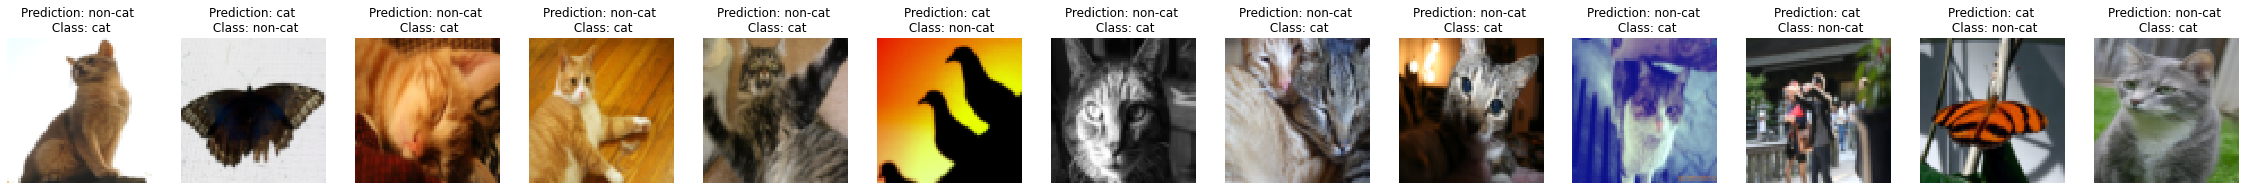

In [44]:
print_mislabeled_images(classes, test_x, test_y, predictions_test)

***Exercise:*** Identify a few types of images that tends to perform poorly on the model

***Report:*** Images with cat but with background contrast similar to cat, different orientation, color, occlusion, shadow and multiple objects perform poorly for the model.

Now, lets use the same architecture to predict sentiment of movie reviews. In this section, most of the implementation is already provided. The exercises are mainly to understand what the workflow is when handling the text data.

In [45]:
import re

# Dataset

**Problem Statement**: You are given a dataset ("train_imdb.txt", "test_imdb.txt") containing:
    - a training set of m_train reviews 
    - a test set of m_test reviews 
    - the labels for the training examples are such that the first 50% belong to class 1 (positive) and the rest 50% of the data belong to class 0(negative)
    
Let's get more familiar with the dataset. Load the data by completing the function and run the cell below.

In [46]:
def load_data(train_file, test_file):
    train_dataset = []
    test_dataset = []
    
    # Read the training dataset file line by line
    for line in open(train_file, 'r', encoding='utf8'):
        train_dataset.append(line.strip())
        
    for line in open(test_file, 'r', encoding='utf8'):
        test_dataset.append(line.strip())
    return train_dataset, test_dataset

In [47]:
train_file = "data/train_imdb.txt"
test_file = "data/test_imdb.txt"
train_dataset, test_dataset = load_data(train_file, test_file)

In [48]:
# This is just how the data is organized. The first 50% data is positive and the rest 50% is negative for both train and test splits.
y = [1 if i < len(train_dataset)*0.5 else 0 for i in range(len(train_dataset))]

As usual, lets check our dataset 

In [49]:
# Example of a review
index = 10
print(train_dataset[index])
print ("y = " + str(y[index]))

I liked the film. Some of the action scenes were very interesting, tense and well done. I especially liked the opening scene which had a semi truck in it. A very tense action scene that seemed well done.<br /><br />Some of the transitional scenes were filmed in interesting ways such as time lapse photography, unusual colors, or interesting angles. Also the film is funny is several parts. I also liked how the evil guy was portrayed too. I'd give the film an 8 out of 10.
y = 1


In [50]:
# Explore your dataset 
m_train = len(train_dataset)
m_test = len(test_dataset)

print ("Number of training examples: " + str(m_train))
print ("Number of testing examples: " + str(m_test))

Number of training examples: 1001
Number of testing examples: 201


## Pre-Processing

From the example review, you can see that the raw data is really noisy! This is generally the case with the text data. Hence, Preprocessing the raw input and cleaning the text is  essential. Please run the code snippet provided below.

**Exercise**: Explain what pattern the model is trying to capture using re.compile in your report. 

In [51]:
REPLACE_NO_SPACE = re.compile("(\.)|(\;)|(\:)|(\!)|(\')|(\?)|(\,)|(\")|(\()|(\))|(\[)|(\])|(\d+)")
REPLACE_WITH_SPACE = re.compile("(<br\s*/><br\s*/>)|(\-)|(\/)")
NO_SPACE = ""
SPACE = " "

def preprocess_reviews(reviews):
    
    reviews = [REPLACE_NO_SPACE.sub(NO_SPACE, line.lower()) for line in reviews]
    reviews = [REPLACE_WITH_SPACE.sub(SPACE, line) for line in reviews]
    
    return reviews

train_dataset_clean = preprocess_reviews(train_dataset)
test_dataset_clean = preprocess_reviews(test_dataset)

***Report:*** re.compile() combines the regular expression pattern of special characters and converts to lowercase as well as replaces html tags like <br> with space.

In [52]:
# Example of a clean review
index = 10
print(train_dataset_clean[index])
print ("y = " + str(y[index]))

i liked the film some of the action scenes were very interesting tense and well done i especially liked the opening scene which had a semi truck in it a very tense action scene that seemed well done some of the transitional scenes were filmed in interesting ways such as time lapse photography unusual colors or interesting angles also the film is funny is several parts i also liked how the evil guy was portrayed too id give the film an  out of 
y = 1


## Vectorization

Now lets create a feature vector for our reviews based on a simple bag of words model. So, given an input text, we need to create a numerical vector which is simply the vector of word counts for each word of the vocabulary. Run the code below to get the feature representation.

In [53]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(binary=True, stop_words="english", max_features=2000)
cv.fit(train_dataset_clean)
X = cv.transform(train_dataset_clean)
X_test = cv.transform(test_dataset_clean)

CountVectorizer provides a sparse feature representation by default which is reasonable because only some words occur in individual example. However, for training neural network models, we generally use a dense representation vector.

In [54]:
X = np.array(X.todense()).astype(float)
X_test = np.array(X_test.todense()).astype(float)
y = np.array(y)

## Model

In [55]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X, y, train_size = 0.80
)

In [56]:
# This is just to correct the shape of the arrays as required by the two_layer_model
X_train = X_train.T
X_val = X_val.T
y_train = y_train.reshape(1,-1)
y_val = y_val.reshape(1,-1)

In [57]:
### CONSTANTS DEFINING THE MODEL ####
n_x = X_train.shape[0]    
n_h = 200
n_y = 1
layers_dims = (n_x, n_h, n_y)

We will use the same two layer model that you completed in the previous section for training.

Loss after iteration 0: 0.6930794161691755
Loss after iteration 100: 0.690075283281354
Loss after iteration 200: 0.6836840756228045
Loss after iteration 300: 0.6653641194544201
Loss after iteration 400: 0.6148463070680608
Loss after iteration 500: 0.5126071783395092
Loss after iteration 600: 0.38910289982819984
Loss after iteration 700: 0.2899036595756565
Loss after iteration 800: 0.2197087297385778
Loss after iteration 900: 0.1702128866142007
Loss after iteration 1000: 0.13458860287328744
Loss after iteration 1100: 0.10840031648734254
Loss after iteration 1200: 0.08875018516384307
Loss after iteration 1300: 0.07372246908489294
Loss after iteration 1400: 0.06203960510737666
Loss after iteration 1500: 0.05284103992236403
Loss after iteration 1600: 0.045517970450541234
Loss after iteration 1700: 0.039627494381771516
Loss after iteration 1800: 0.03483889488454306
Loss after iteration 1900: 0.030904356252072645
Loss after iteration 2000: 0.027636201093741618
Loss after iteration 2100: 0.02

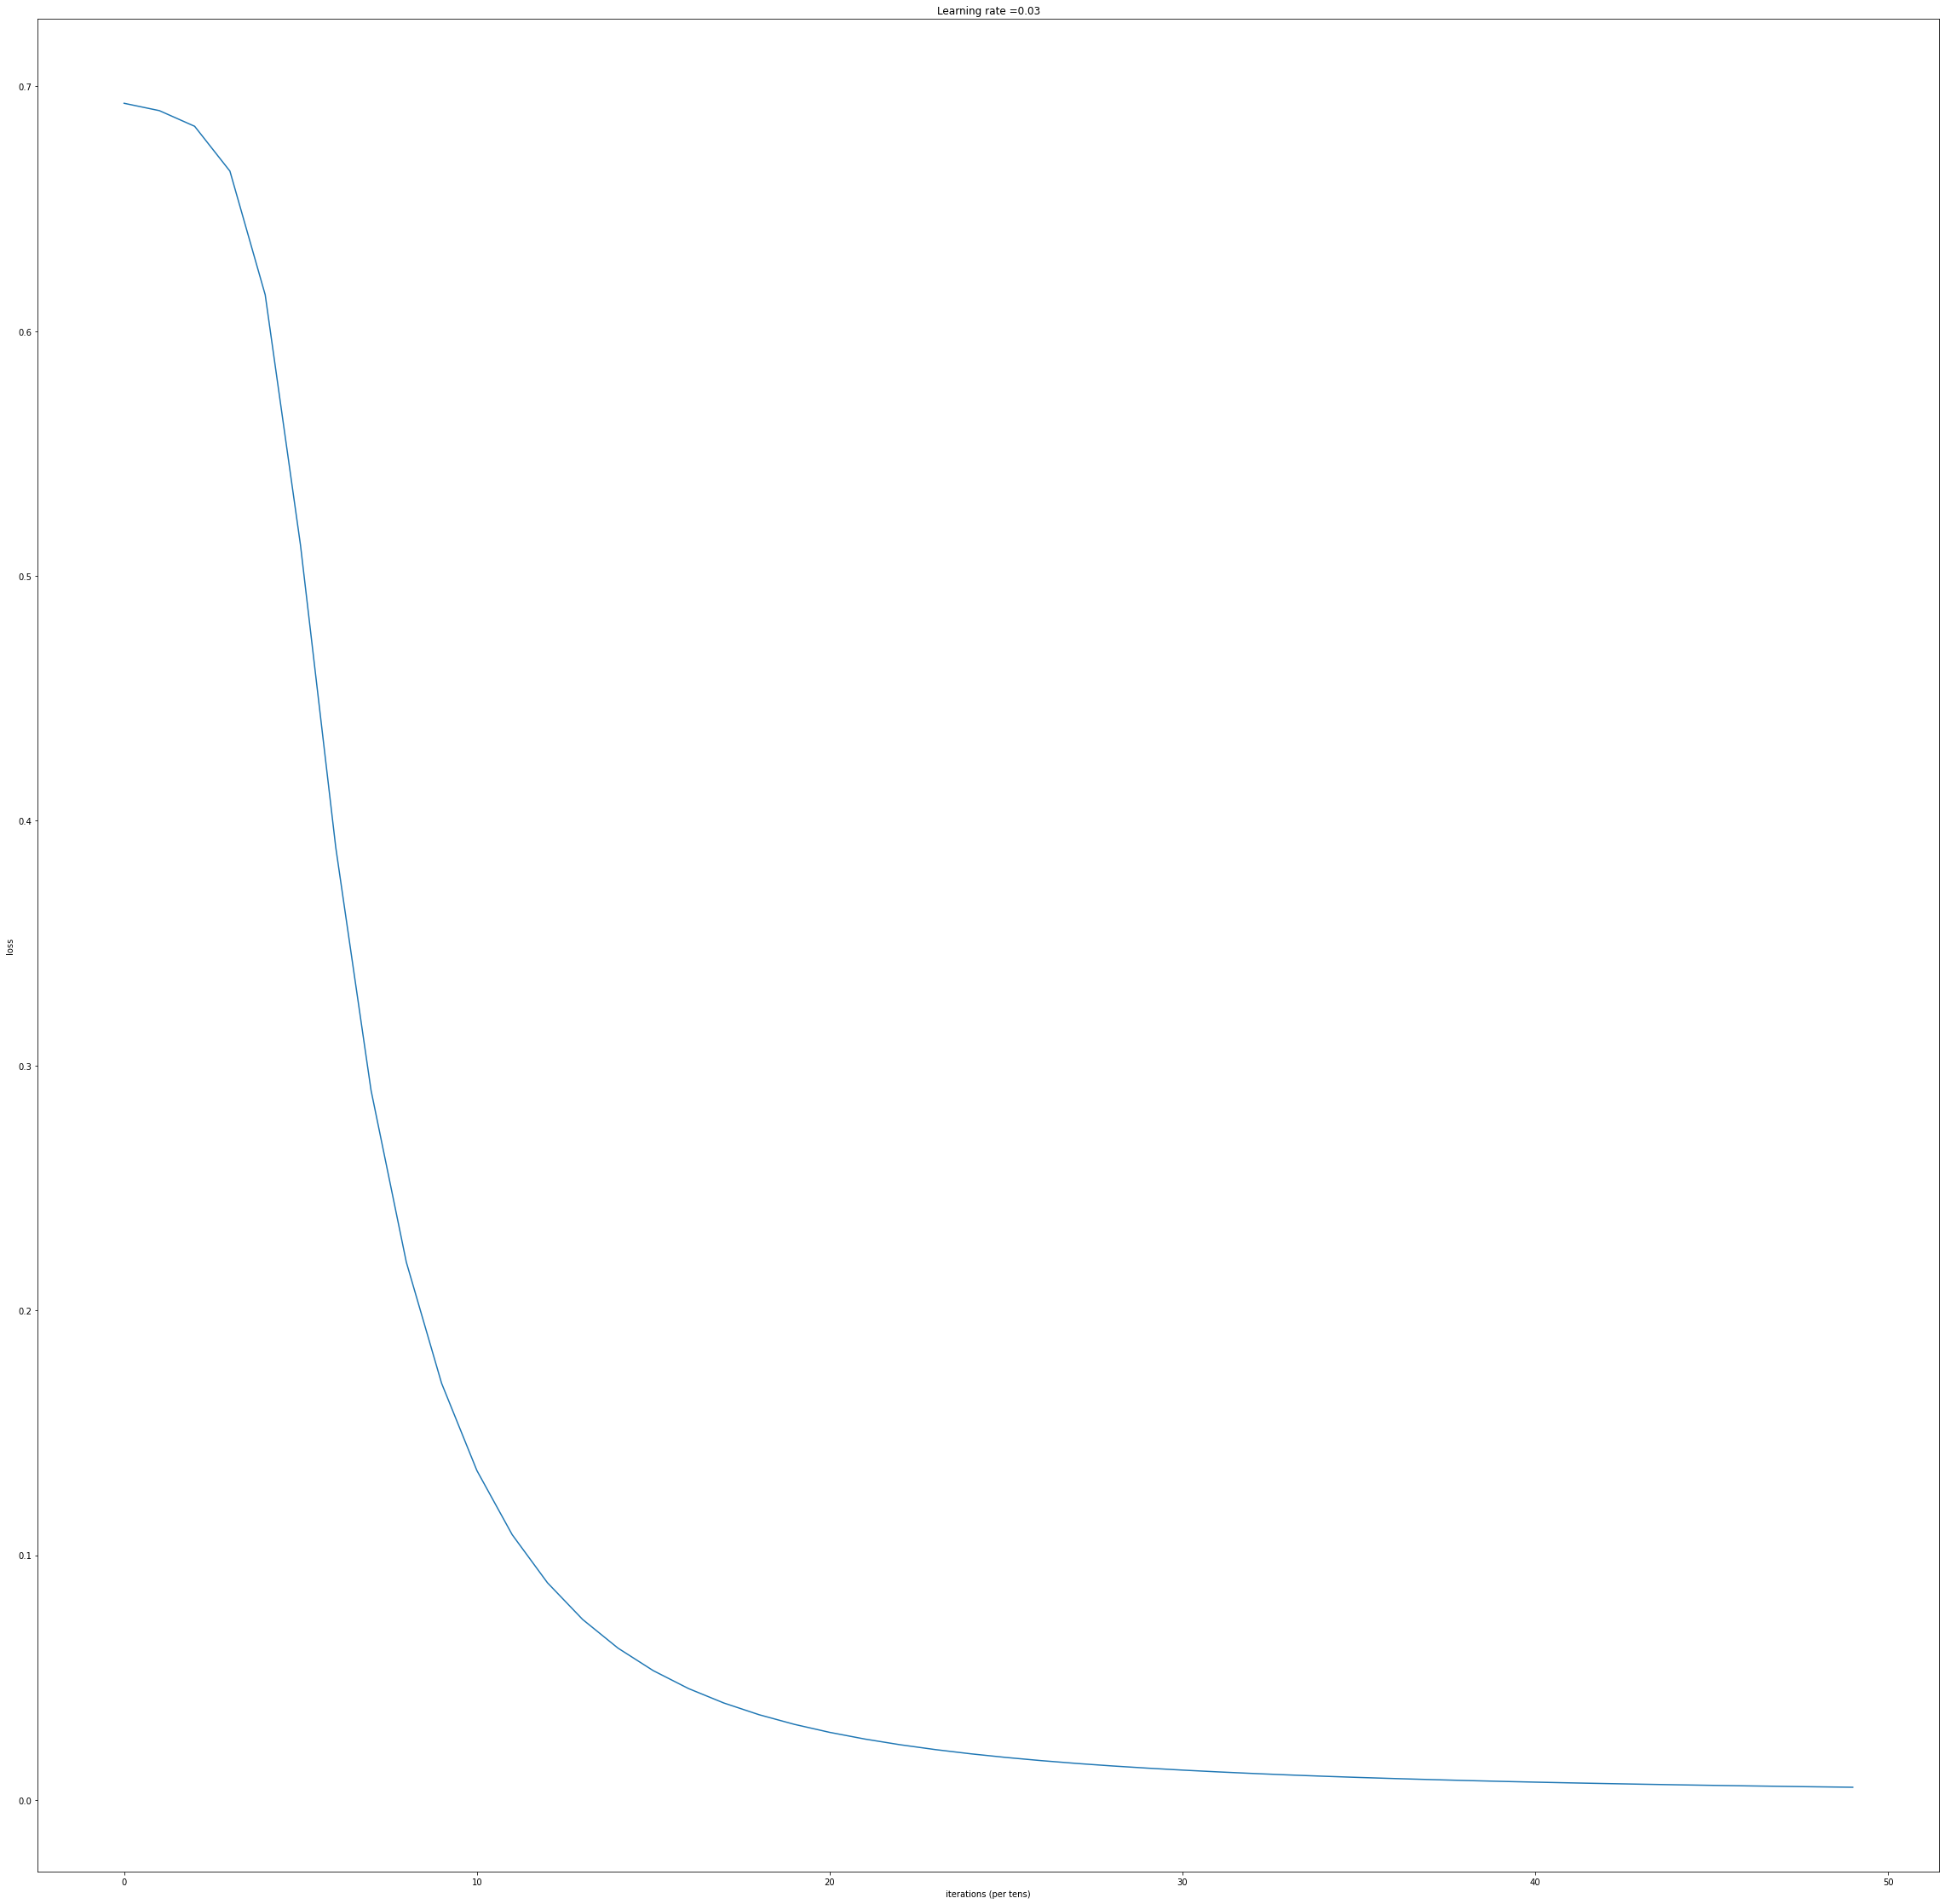

In [58]:
parameters = two_layer_model(X_train, y_train, layers_dims = (n_x, n_h, n_y), learning_rate=0.03, num_iterations = 5000, print_loss=True)

## Predict the review for our movies!

In [59]:
predictions_train = predict(X_train, y_train, parameters)

Accuracy: 0.9999999999999998


In [60]:
predictions_val = predict(X_val, y_val, parameters)

Accuracy: 0.8507462686567162


##  Results Analysis

Let's take a look at some examples the 2-layer model labeled incorrectly

In [61]:
def print_mislabeled_reviews(X, y, p):
    """
    Plots images where predictions and truth were different.
    X -- dataset
    y -- true labels
    p -- predictions
    """
    a = p + y
    mislabeled_indices = np.asarray(np.where(a == 1))
    plt.rcParams['figure.figsize'] = (40.0, 40.0) # set default size of plots
    num_reviews = len(mislabeled_indices[0])
    for i in range(num_reviews):
        index = mislabeled_indices[1][i]
        
        print((" ").join(cv.inverse_transform(X[index])[0]))
        print("Prediction: " + str(int(p[0,index])) + " \nClass: " + str(y[0,index]) + "\n")

In [62]:
print_mislabeled_reviews(X_val.T, y_val, predictions_val)

actors attempt beauty believable big bit charismatic claims definitely delivery did didnt disappointing disaster entertained fact film fine group job line looked lost miss offensive performance playing plays plot project recommend rent scenes screen seen strong talent wish writing
Prediction: 0 
Class: 1

acting add annoying bad change character dicaprio did director does eyes film filmmakers films glad going good great half hand hardly impressive just kate learned lesson love mean million movie opinion oscar performance possible really romance romantic second ship shouldnt single sit stories story sure talented think thinking time times titanic try watching win wonderful wont worst
Prediction: 0 
Class: 1

anna appearance away bad better bible big black blue book boys build capture cat catch chaos charles child city comic connected cops cult deal didnt doesnt earth edge exactly extreme far favorite fictional fine finished followed fond form fun gang gas genius giant god going good got

**Exercise**: Provide explanation as to why these examples were misclassified below.

**Report:**  The classification solely relies on the number of words in positive and negative reviews. However, the context of phrases the words are used in determine the overall sentiment(For example, "not good"). Also, the relative ordering and context of the text adds more value to the sentiment.